In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
inspector = inspect(engine)

In [12]:
#inspect measurement table
measurements = inspector.get_columns("measurement")

for measurement in measurements:
    print(measurement["name"], measurement["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
#inspect station table
stations = inspector.get_columns("station")

for station in stations:
    print(station["name"],station["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
engine.execute('select * from measurement limit 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

# Exploratory Climate Analysis

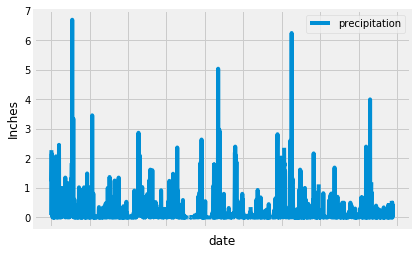

In [50]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(2017,8,23) - dt.timedelta(weeks=52)

# Perform a query to retrieve the data and precipitation scores
lasttwelvemonths = (session.query(Measurement.date, Measurement.prcp)
                   .filter(func.strftime(Measurement.date)>=query_date)
                   .order_by(Measurement.date)
                   .all())

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(lasttwelvemonths, columns=["date","precipitation"])

# Use Pandas Plotting with Matplotlib to plot the data
df.set_index('date').head()
df.plot('date')
plt.xticks(rotation=45)
#plt.title("Precipitation")
plt.locator_params(nbins=12, axis= "x")
#plt.tick_params(
    #axis='x',          # changes apply to the x-axis
    #which='both',      # both major and minor ticks are affected
    #bottom=False,      # ticks along the bottom edge are off
    #top=False,         # ticks along the top edge are off
    #labelbottom=False) # labels along the bottom edge are off
plt.ylabel('Inches')
plt.show()

![precipitation](Images/precipitation.png)

In [43]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [17]:
# Design a query to show how many stations are available in this dataset?
stations_s = session.query(Station.station).count()
stations_m = session.query(Measurement.station).group_by(Measurement.station).count()
print(stations_s)
print(stations_m)

9
9


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

stations_count = (session.query(Measurement.station, func.count(Measurement.tobs))
                  .group_by(Measurement.station)
                  .order_by(func.count(Measurement.tobs).desc())
                  .all())
stations_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

most_active = (session.query(Measurement.station,
                             func.max(Measurement.tobs),
                             func.min(Measurement.tobs),
                             func.avg(Measurement.tobs))
              .filter(Measurement.station == "USC00519281")
              .all())
most_active

[('USC00519281', 85.0, 54.0, 71.66378066378067)]

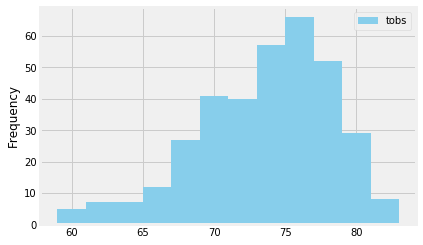

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_12_months= (session.query(Measurement.date, Measurement.tobs)
                 .filter(Measurement.station == "USC00519281")
                 .filter(func.strftime(Measurement.date)>=query_date).all())

tobs12= pd.DataFrame(tobs_12_months).set_index('date')

#Plot the results as a histogram with bins=12.
num_bins = 12
x= tobs12['tobs']
plt.hist(x,num_bins, color='skyblue')
plt.legend(tobs12)
plt.ylabel('Frequency')

plt.show()

![precipitation](Images/station-histogram.png)

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = calc_temps("2017-02-22","2017-02-27")

In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

In [ ]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
